Notebook for modelling empirical data from finger lakes

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit 
# from temp_module.tempmb import TempMb as tmb

In [2]:
def select(adcp, flx, start, end, depth=0):
    """function to choose data to work with by lake and time interal, choose a depth to create tables of a single depth"""
    adcp['time'] = pd.to_datetime(adcp['time'])
    select_adp = adcp[(adcp['time'] > start) & (adcp['time'] < end)]

    flx['time'] = pd.to_datetime(flx['Timestamp_EST'])
    flx = flx[['time', 'Temperature_C', 'Depth_m']]
    select_flx = flx[(flx['time'] > start) & (flx['time'] < end)]

    if depth > 0:
        select_adp = select_adp[['time', str(depth)+".61"]]
        select_flx = select_flx[select_flx["Depth_m"] == depth]

    def drop(tbl,n):
        # Dropping last n rows using drop
        tbl.drop(tbl.tail(n).index, inplace = True)
        # randomly drop data to make dfs the same length 
        np.random.seed(10)
        drop_indices = np.random.choice(tbl.index, n, replace=False)
        tbl_drop = tbl.drop(drop_indices)
        return(tbl_drop.head())

    # compare the two existing sets, and make the same size through random removal of excess rows
    # TODO refactor the next block using either pd.resample(..., ) OR pd.merge_asof(..., method=nearest)

    print(len(select_adp),"adp")
    select_adp = select_adp.iloc[::3]
    print(len(select_flx), "flx", len(select_adp), "adp")

    if len(select_adp) > len(select_flx):
        n = len(select_adp) - len(select_flx)
        drop(select_adp, n)
        print("Dropped "+str(n)+" random values from sel_adp")
    else:
        n = np.abs(len(select_flx) - len(select_adp))
        drop(select_flx, n)
        print("Dropped "+str(n)+" random values from select_flx")

    print(len(select_flx), "flx", len(select_adp), "adp")
    return(select_adp, select_flx)

In [3]:
def model_fit(adcp, flx, start, end, depth=0):
    sel = select(adcp, flx, start, end, depth=depth)
    sel_adp, sel_flx = sel[0], sel[1]
    # the general form used is amp(temp, depth) and will be inverted in the plotting
    backscatter = sel_adp.iloc[:,1] # backscatter
    temperature = sel_flx['Temperature_C'] 

    # general form found from rearranging existing theory to find temp(amp)
    def fit(x, a, b):
        return ((x + a) * 10**(1520/(x + 273)))/b
    
    # parameter fit using the above x, y values and temp function
    popt, pcov = curve_fit(fit, temperature, backscatter)
    popt, pcov

    mb_temp = fit(temperature, popt[0], popt[1])

    plt.scatter(backscatter, temperature, marker= 'x', color='black')
    plt.scatter(mb_temp, temperature, marker = '+', color='red') # ,popt[2],popt[3]))

    plt.grid()
    plt.xlabel('Measured Backscatter (dB)')
    plt.ylabel('Temp (c)')
    plt.rcParams["figure.figsize"] = (12,8)
    plt.title('T(Measured Backscatter) Data fit')
    plt.xlim(60,75)

Pull the data

In [5]:
# pull the adcp tables
lake = "OWS19"
directory = "/home/mpoe/adcp_habs/data/adcp_tables_stacked/"
adp = pd.read_csv(directory + "/" + lake + "/" + lake + "_mb_av.csv")
adp_ts = pd.read_csv(directory + "/" + lake + "/" + lake + "_converted_time_series.csv")

# flx csv
flx = pd.read_csv("/home/mpoe/adcp_habs/data/flx_data/flx_most_recent.csv").dropna()
# site number to lake name 
seneca, owasco, skaneateles = (flx.Site.unique()[0], flx.Site.unique()[1], flx.Site.unique()[2])
# separate dfs by lake
sen, ows, skn = (flx[flx["Site"] == seneca], flx[flx["Site"] == owasco], flx[flx["Site"] == skaneateles])

Produce the model fit from the data

/tmp/ipykernel_18941/841452517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flx['time'] = pd.to_datetime(flx['Timestamp_EST'])


9215 adp
3068 flx 3072 adp
Dropped 4 random values from sel_adp
3068 flx 3068 adp


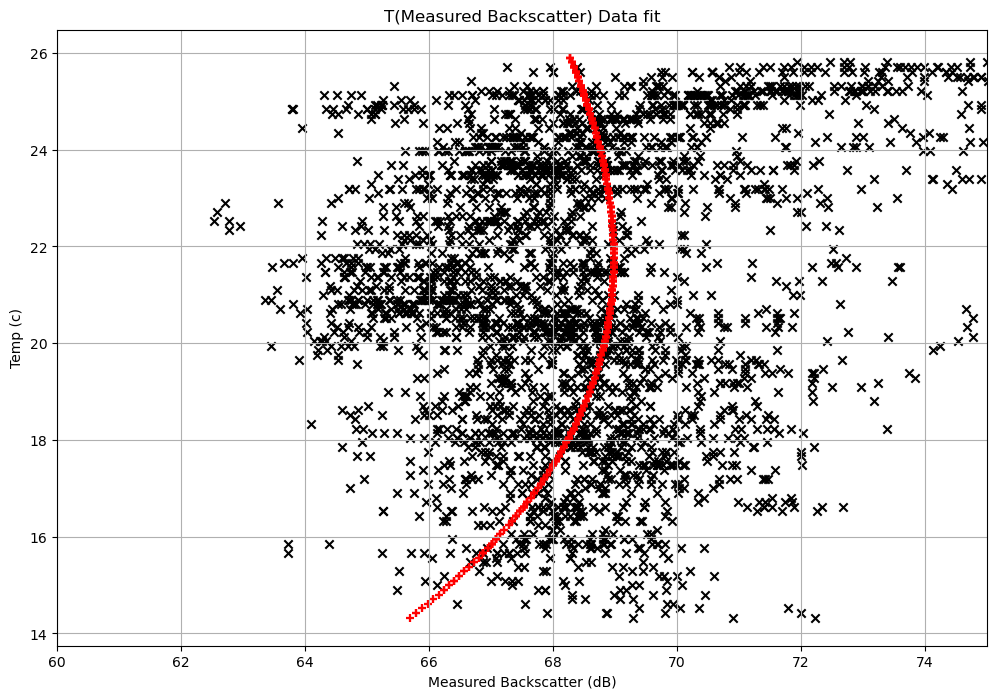

In [7]:
# choose lake, year, interval and depth
start = "2019-07-01 12:00:00"
end = "2019-08-02 12:00:00"
dpth = 8 # depth in meters

# plot
model_fit(adp, ows, start, end, depth=dpth)

Explore general standard deviations of our sets

In [8]:
from scipy import stats

In [14]:
sel_adp = select(adp, ows, start, end, depth =dpth)[0]
mb_vals = sel_adp.iloc[:,1]
# sel_flx = 

9215 adp
3068 flx 3072 adp
Dropped 4 random values from sel_adp
3068 flx 3068 adp


/tmp/ipykernel_18941/841452517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flx['time'] = pd.to_datetime(flx['Timestamp_EST'])


In [16]:
stats.tstd(mb_vals,(60,80))


2.3433080712440004

In [51]:
# sel = select(adp, ows, start, end, depth=dpth)
# sel_adp, sel_flx = sel[0], sel[1]

In [19]:
# plt.plot(sel_flx['Timestamp_EST'],sel_flx['Temperature_C'],)
# plt.grid()
# plt.xlabel('Time')
# plt.ylabel('Temperature')

In [45]:
# merged_df = pd.merge_asof(sel_adp, sel_flx, on='time', by='').dropna()
# len(merged_df)